In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import lfilter, firwin
from scipy.fftpack import fft,fftshift
from scipy import signal
from tool._fixedInt import *
from random import *


# <u> Filter analysis testbench generation </u>

## Frequency response
First we obtain the filter frequency response.


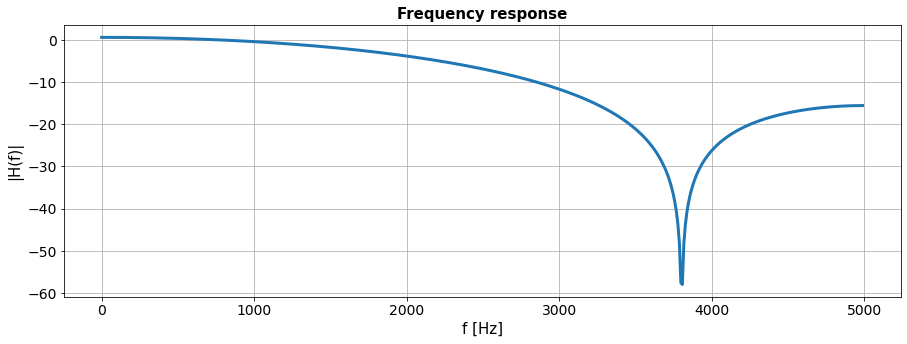

In [3]:
fs = 10000     # 10kHz 
N           = 3

NB_DATA     = 4
NBF_DATA    = 3

b  = [0.3094, 0.4521, 0.3094]

w, h = signal.freqz(b=b, a=1)
x = w*fs*1/(2*np.pi)
y = 20*np.log10(abs(h))

plt.figure(figsize=(15,5))
plt.plot(x,y, linewidth=3)
plt.title("Frequency response", fontweight="bold", fontsize=15)
plt.xlabel("f [Hz]", fontsize=15)
plt.ylabel("|H(f)|", fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)

## Input signal generation
Now, a sinusoidal signal is generated, consisting of two tones. One tone should pass through the filter, while the other should appear significantly attenuated.

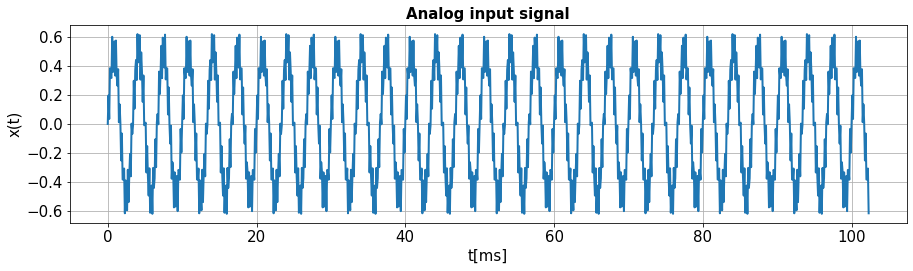

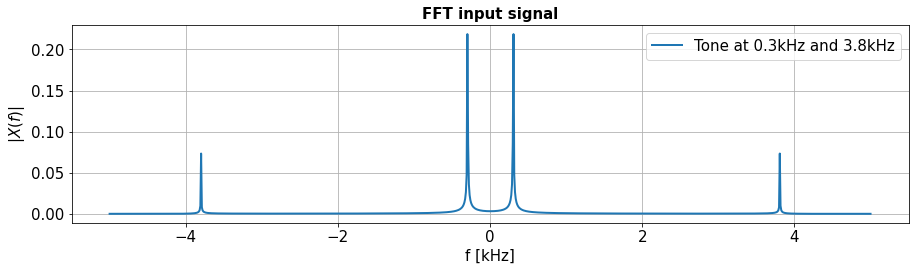

In [6]:
f1 = 300        # 300Hz
f2 = 3800       # 3.8kHz
N  = 1024       # 5000 samples
Ts = 1/fs
NFFT = 1024
t = np.arange(N)*Ts
f = np.linspace(-fs/2, fs/2, NFFT)
n = np.arange(0,len(t))

x = 0.5*np.sin(2*np.pi*f1*t) + 0.15*np.sin(2*np.pi*f2*t)

X = fft(x, NFFT)
X = fftshift(X)

plt.figure(figsize=(15,8))
plt.subplot(2,1,1)
plt.plot(t/1e-3,x, linewidth=2)
plt.title("Analog input signal", fontsize=15, fontweight="bold")
plt.xlabel("t[ms]", fontsize=15)
plt.ylabel("x(t)", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True)

plt.figure(figsize=(15,8))
plt.subplot(2,1,2)
plt.plot(f/1e3,1/NFFT*np.abs(X), linewidth=2, label=f"Tone at {f1/1e3}kHz and {f2/1e3}kHz")
plt.title("FFT input signal", fontsize=15, fontweight="bold")
plt.xlabel("f [kHz]", fontsize=15)
plt.ylabel("$|X(f)|$", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='best', fontsize=15)
plt.grid(True)

# Quantization
xn = arrayFixedInt(NB_DATA, NBF_DATA, x)

input_sig = open("input.mem","w")
for i in xn:
    input_sig.write(f"0x{i.__hex__()}\n")
input_sig.close()

# Filter generation

In [7]:
def filtro_fir(b, x):
        partial_prod = [DeFixedInt(NB_DATA, NBF_DATA), DeFixedInt(NB_DATA, NBF_DATA), DeFixedInt(NB_DATA, NBF_DATA)]
        partial_sum  = [DeFixedInt(NB_DATA, NBF_DATA), DeFixedInt(NB_DATA, NBF_DATA)]

        partial_prod[0].value = b[0] * x[0]
        partial_prod[1].value = b[1] * x[1]
        partial_prod[2].value = b[2] * x[2]

        partial_sum[0].value = partial_prod[0].fValue   + partial_prod[1].fValue
        partial_sum[1].value = partial_sum[0].fValue    + partial_prod[2].fValue

        return partial_sum[1].fValue, partial_sum[1].__hex__()
        

## <u> Signal filtering </u>

0.25
0.375
0.25


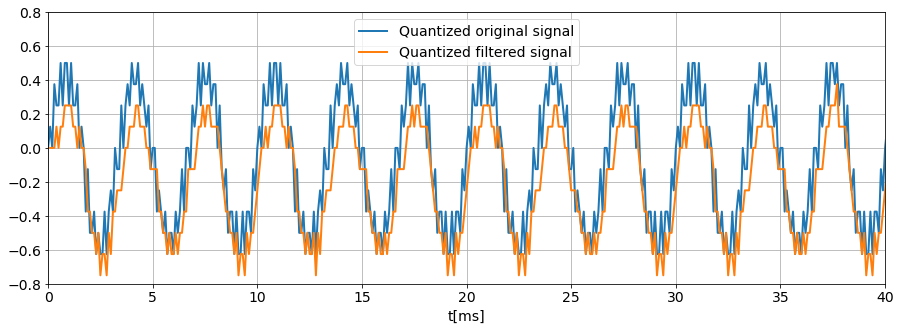

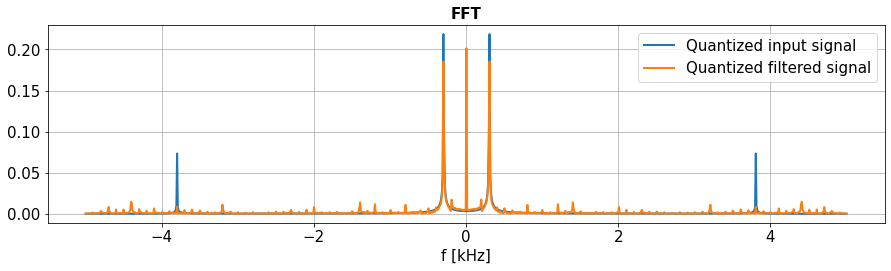

In [8]:
# The first N-1 samples are corrupted
warmup = len(b)-1
delay = warmup/2*Ts
b_fixed = arrayFixedInt(NB_DATA, NBF_DATA, b)
b_fp  = [i.fValue for i in b_fixed]

# Printing fixed point coefficients S(4,3)
for i in b_fp:
    print(i)

x_fp = [i.fValue for i in xn]

# x_filtered = lfilter(b_fp, 1, x_fp)
x_filtered = []
x_hex      = []
x_reg = [0.0, 0.0, 0.0]
for i in x_fp:
    y,hex_val = filtro_fir(b_fp, x_reg)
    x_filtered.append(y)
    x_reg[2] = x_reg[1]
    x_reg[1] = x_reg[0]
    x_reg[0] = i
    x_hex.append(hex_val)

output_signal = open("output.mem","w")
for i in x_hex:
    output_signal.write(f"0x{i}\n")
output_signal.close()

plt.figure(figsize=(15,5))
plt.plot(t/1e-3,x_fp, linewidth=2, label="Quantized original signal")
plt.plot((t[warmup:]-delay)/1e-3,x_filtered[warmup:], linewidth=2, label="Quantized filtered signal")
plt.legend(fontsize=14)
plt.grid(True)
plt.xlabel("t[ms]", fontsize=14)
plt.xlim([0, 40])
plt.ylim([-0.8, 0.8])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

X_FILTERED = fft(x_filtered, NFFT)
X_FILTERED = fftshift(X_FILTERED)


plt.figure(figsize=(15,8))
plt.subplot(2,1,1)
plt.plot(f/1e3,1/NFFT*np.abs(X), linewidth=2, label="Quantized input signal")
plt.plot(f/1e3,1/NFFT*np.abs(X_FILTERED), linewidth=2, label="Quantized filtered signal")
plt.title("FFT", fontsize=15, fontweight="bold")
plt.xlabel("f [kHz]", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='best', fontsize=15)
plt.grid(True)
